# 程序说明
时间：2018年1月3日

说明：该程序构造一个基于变分自动编码器的加法器。

Reference: ["Auto-Encoding Variational Bayes"](https://arxiv.org/abs/1312.6114)

数据集：MNIST

## 1.加载keras模块

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Input, Dense, Lambda, Add, concatenate
from keras.models import Model, load_model
from keras import backend as K
from keras import objectives
import h5py
#from keras.datasets import mnist
import sum_input

## 2.变量初始化

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 32
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 1.0

x = Input(batch_shape=(batch_size, original_dim),name='x_input')
x2 = Input(batch_shape=(batch_size, original_dim),name='x2_input')
x_sum = Input(batch_shape=(batch_size, original_dim),name='sum_input')

hidden_ly = Dense(intermediate_dim, activation='relu',name='Dense_1')
mn_ly = Dense(latent_dim)
var_ly = Dense(latent_dim)

h = hidden_ly(x)
z_mean = mn_ly(h)
z_log_var = var_ly(h)

h2 = hidden_ly(x2)
z_mean2 = mn_ly(h2)
z_log_var2 = var_ly(h2)



In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z = Lambda(sampling)([z_mean, z_log_var])
z2 = Lambda(sampling)([z_mean2, z_log_var2])

In [5]:
# we instantiate these layers separately so as to reuse them later
decoder_h_ly = Dense(intermediate_dim, activation='relu',name='Dense_3')
decoder_mean_ly = Dense(original_dim, activation='sigmoid',name='Dense_4')

h_decoded = decoder_h_ly(z) #####
x_decoded_mean = decoder_mean_ly(h_decoded)

h_decoded2 = decoder_h_ly(z2) #####
x_decoded_mean2 = decoder_mean_ly(h_decoded2)

decoder_h_sum_ly = Dense(intermediate_dim, activation='relu',name='Dense_7')
decoder_mean_sum_ly = Dense(original_dim, activation='sigmoid',name='Dense_8')
#added_z = Add()([z, z2])
added_z = concatenate([z, z2], axis=-1)
h_decoded_sum = decoder_h_sum_ly(added_z) #####
decoded_mean_sum = decoder_mean_sum_ly(h_decoded_sum)

In [6]:
def vae_loss(inputs=[x, x2, x_sum], outputs=[x_decoded_mean, x_decoded_mean2, decoded_mean_sum]):
    xent_loss = original_dim * objectives.binary_crossentropy(x_sum, decoded_mean_sum)
    x_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    x2_loss = original_dim * objectives.binary_crossentropy(x2, x_decoded_mean2)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return 3*xent_loss + x_loss + x2_loss + kl_loss

In [7]:
vae = Model(inputs=[x, x2, x_sum], outputs=[x_decoded_mean, x_decoded_mean2, decoded_mean_sum])
#vae = Model(x_sum, x, x2, x_decoded_mean, x_decoded_mean2, decoded_mean_sum)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [8]:
# train the VAE on MNIST digits
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
mnist = sum_input.read_data_sets('./Data')
#batch_1, batch_2, batch_3 = mnist.train.next_batch(40000)


Extracting ./Data/train-images-idx3-ubyte.gz
Extracting ./Data/train-labels-idx1-ubyte.gz
Extracting ./Data/t10k-images-idx3-ubyte.gz
Extracting ./Data/t10k-labels-idx1-ubyte.gz
(5444, 784)
(6179, 784)
(5470, 784)
(5638, 784)
(5307, 784)
(4987, 784)
(5417, 784)
(5715, 784)
(5389, 784)
(5454, 784)
(980, 784)
(1135, 784)
(1032, 784)
(1010, 784)
(982, 784)
(892, 784)
(958, 784)
(1028, 784)
(974, 784)
(1009, 784)


In [23]:
vae=load_model('model.h5')

ImportError: `load_model` requires h5py.

In [89]:
#vae.fit({'x_input':batch_1, 'x2_input':batch_2, 'sum_input':batch_3},{'input_4':batch_1, 'input_5':batch_2, 'input_6':batch_3},
#        shuffle=False,
#        epochs=nb_epoch,
#        batch_size=batch_size)
for i in np.arange(30):
    batch_1, batch_2, batch_3 = mnist.train.next_batch(10000)
    print(i)
    vae.fit([batch_1, batch_2, batch_3],[batch_1, batch_2, batch_3],
         shuffle=False,
         epochs=100,
         batch_size=batch_size)
# build a model to project inputs on the latent space


0
Epoch 1/100
10000/10000 [==============================] - 2s 162us/step - loss: 3272.2105 - Dense_4_loss_1: 1090.7368 - Dense_4_loss_2: 1090.7368 - Dense_8_loss: 1090.7368
Epoch 2/100
10000/10000 [==============================] - 1s 56us/step - loss: 2712.1419 - Dense_4_loss_1: 904.0473 - Dense_4_loss_2: 904.0473 - Dense_8_loss: 904.0473
Epoch 3/100
10000/10000 [==============================] - 1s 56us/step - loss: 2561.5392 - Dense_4_loss_1: 853.8464 - Dense_4_loss_2: 853.8464 - Dense_8_loss: 853.8464
Epoch 4/100
10000/10000 [==============================] - 1s 56us/step - loss: 2459.0151 - Dense_4_loss_1: 819.6717 - Dense_4_loss_2: 819.6717 - Dense_8_loss: 819.6717
Epoch 5/100
10000/10000 [==============================] - 1s 56us/step - loss: 2384.0159 - Dense_4_loss_1: 794.6720 - Dense_4_loss_2: 794.6720 - Dense_8_loss: 794.6720
Epoch 6/100
10000/10000 [==============================] - 1s 65us/step - loss: 2324.0374 - Dense_4_loss_1: 774.6791 - Dense_4_loss_2: 774.6791 - Den

10000/10000 [==============================] - 1s 55us/step - loss: 1731.8255 - Dense_4_loss_1: 577.2752 - Dense_4_loss_2: 577.2752 - Dense_8_loss: 577.2752
Epoch 98/100
10000/10000 [==============================] - 1s 54us/step - loss: 1729.5743 - Dense_4_loss_1: 576.5248 - Dense_4_loss_2: 576.5248 - Dense_8_loss: 576.5248
Epoch 99/100
10000/10000 [==============================] - 1s 55us/step - loss: 1729.3272 - Dense_4_loss_1: 576.4424 - Dense_4_loss_2: 576.4424 - Dense_8_loss: 576.4424
Epoch 100/100
10000/10000 [==============================] - 1s 54us/step - loss: 1727.2191 - Dense_4_loss_1: 575.7397 - Dense_4_loss_2: 575.7397 - Dense_8_loss: 575.7397
1
Epoch 1/100
10000/10000 [==============================] - 1s 54us/step - loss: 2161.6324 - Dense_4_loss_1: 720.5441 - Dense_4_loss_2: 720.5441 - Dense_8_loss: 720.5441
Epoch 2/100
10000/10000 [==============================] - 1s 54us/step - loss: 2071.0443 - Dense_4_loss_1: 690.3481 - Dense_4_loss_2: 690.3481 - Dense_8_loss: 6

10000/10000 [==============================] - 1s 55us/step - loss: 1691.2987 - Dense_4_loss_1: 563.7662 - Dense_4_loss_2: 563.7662 - Dense_8_loss: 563.7662
Epoch 94/100
10000/10000 [==============================] - 1s 55us/step - loss: 1688.9757 - Dense_4_loss_1: 562.9919 - Dense_4_loss_2: 562.9919 - Dense_8_loss: 562.9919
Epoch 95/100
10000/10000 [==============================] - 1s 54us/step - loss: 1688.8600 - Dense_4_loss_1: 562.9533 - Dense_4_loss_2: 562.9533 - Dense_8_loss: 562.9533
Epoch 96/100
10000/10000 [==============================] - 1s 55us/step - loss: 1687.5173 - Dense_4_loss_1: 562.5058 - Dense_4_loss_2: 562.5058 - Dense_8_loss: 562.5058
Epoch 97/100
10000/10000 [==============================] - 1s 55us/step - loss: 1688.1940 - Dense_4_loss_1: 562.7313 - Dense_4_loss_2: 562.7313 - Dense_8_loss: 562.7313
Epoch 98/100
10000/10000 [==============================] - 1s 54us/step - loss: 1687.0558 - Dense_4_loss_1: 562.3519 - Dense_4_loss_2: 562.3519 - Dense_8_loss: 56

10000/10000 [==============================] - 1s 56us/step - loss: 1687.0176 - Dense_4_loss_1: 562.3392 - Dense_4_loss_2: 562.3392 - Dense_8_loss: 562.3392
Epoch 90/100
10000/10000 [==============================] - 1s 56us/step - loss: 1688.0489 - Dense_4_loss_1: 562.6830 - Dense_4_loss_2: 562.6830 - Dense_8_loss: 562.6830
Epoch 91/100
10000/10000 [==============================] - 1s 56us/step - loss: 1685.3578 - Dense_4_loss_1: 561.7859 - Dense_4_loss_2: 561.7859 - Dense_8_loss: 561.7859
Epoch 92/100
10000/10000 [==============================] - 1s 56us/step - loss: 1685.5237 - Dense_4_loss_1: 561.8412 - Dense_4_loss_2: 561.8412 - Dense_8_loss: 561.8412
Epoch 93/100
10000/10000 [==============================] - 1s 57us/step - loss: 1684.4313 - Dense_4_loss_1: 561.4771 - Dense_4_loss_2: 561.4771 - Dense_8_loss: 561.4771
Epoch 94/100
10000/10000 [==============================] - 1s 57us/step - loss: 1683.7645 - Dense_4_loss_1: 561.2548 - Dense_4_loss_2: 561.2548 - Dense_8_loss: 56

10000/10000 [==============================] - 1s 55us/step - loss: 1694.1449 - Dense_4_loss_1: 564.7150 - Dense_4_loss_2: 564.7150 - Dense_8_loss: 564.7150
Epoch 86/100
10000/10000 [==============================] - 1s 55us/step - loss: 1693.3439 - Dense_4_loss_1: 564.4480 - Dense_4_loss_2: 564.4480 - Dense_8_loss: 564.4480
Epoch 87/100
10000/10000 [==============================] - 1s 54us/step - loss: 1691.9199 - Dense_4_loss_1: 563.9733 - Dense_4_loss_2: 563.9733 - Dense_8_loss: 563.9733
Epoch 88/100
10000/10000 [==============================] - 1s 54us/step - loss: 1691.1096 - Dense_4_loss_1: 563.7032 - Dense_4_loss_2: 563.7032 - Dense_8_loss: 563.7032
Epoch 89/100
10000/10000 [==============================] - 1s 54us/step - loss: 1690.5803 - Dense_4_loss_1: 563.5268 - Dense_4_loss_2: 563.5268 - Dense_8_loss: 563.5268
Epoch 90/100
10000/10000 [==============================] - 1s 55us/step - loss: 1690.4106 - Dense_4_loss_1: 563.4702 - Dense_4_loss_2: 563.4702 - Dense_8_loss: 56

10000/10000 [==============================] - 1s 55us/step - loss: 1694.9898 - Dense_4_loss_1: 564.9966 - Dense_4_loss_2: 564.9966 - Dense_8_loss: 564.9966
Epoch 82/100
10000/10000 [==============================] - 1s 55us/step - loss: 1694.7203 - Dense_4_loss_1: 564.9068 - Dense_4_loss_2: 564.9068 - Dense_8_loss: 564.9068
Epoch 83/100
10000/10000 [==============================] - 1s 55us/step - loss: 1695.1523 - Dense_4_loss_1: 565.0508 - Dense_4_loss_2: 565.0508 - Dense_8_loss: 565.0508
Epoch 84/100
10000/10000 [==============================] - 1s 55us/step - loss: 1692.7602 - Dense_4_loss_1: 564.2534 - Dense_4_loss_2: 564.2534 - Dense_8_loss: 564.2534
Epoch 85/100
10000/10000 [==============================] - 1s 55us/step - loss: 1693.0432 - Dense_4_loss_1: 564.3477 - Dense_4_loss_2: 564.3477 - Dense_8_loss: 564.3477
Epoch 86/100
10000/10000 [==============================] - 1s 55us/step - loss: 1690.4751 - Dense_4_loss_1: 563.4917 - Dense_4_loss_2: 563.4917 - Dense_8_loss: 56

10000/10000 [==============================] - 1s 55us/step - loss: 1710.9274 - Dense_4_loss_1: 570.3091 - Dense_4_loss_2: 570.3091 - Dense_8_loss: 570.3091
Epoch 78/100
10000/10000 [==============================] - 1s 54us/step - loss: 1710.2628 - Dense_4_loss_1: 570.0876 - Dense_4_loss_2: 570.0876 - Dense_8_loss: 570.0876
Epoch 79/100
10000/10000 [==============================] - 1s 55us/step - loss: 1710.0116 - Dense_4_loss_1: 570.0039 - Dense_4_loss_2: 570.0039 - Dense_8_loss: 570.0039
Epoch 80/100
10000/10000 [==============================] - 1s 54us/step - loss: 1708.1182 - Dense_4_loss_1: 569.3727 - Dense_4_loss_2: 569.3727 - Dense_8_loss: 569.3727
Epoch 81/100
10000/10000 [==============================] - 1s 54us/step - loss: 1707.2004 - Dense_4_loss_1: 569.0668 - Dense_4_loss_2: 569.0668 - Dense_8_loss: 569.0668
Epoch 82/100
10000/10000 [==============================] - 1s 55us/step - loss: 1706.4951 - Dense_4_loss_1: 568.8317 - Dense_4_loss_2: 568.8317 - Dense_8_loss: 56

10000/10000 [==============================] - 1s 55us/step - loss: 1715.7348 - Dense_4_loss_1: 571.9116 - Dense_4_loss_2: 571.9116 - Dense_8_loss: 571.9116
Epoch 74/100
10000/10000 [==============================] - 1s 55us/step - loss: 1715.4930 - Dense_4_loss_1: 571.8310 - Dense_4_loss_2: 571.8310 - Dense_8_loss: 571.8310
Epoch 75/100
10000/10000 [==============================] - 1s 55us/step - loss: 1714.5246 - Dense_4_loss_1: 571.5082 - Dense_4_loss_2: 571.5082 - Dense_8_loss: 571.5082
Epoch 76/100
10000/10000 [==============================] - 1s 55us/step - loss: 1712.8113 - Dense_4_loss_1: 570.9371 - Dense_4_loss_2: 570.9371 - Dense_8_loss: 570.9371
Epoch 77/100
10000/10000 [==============================] - 1s 55us/step - loss: 1712.7473 - Dense_4_loss_1: 570.9158 - Dense_4_loss_2: 570.9158 - Dense_8_loss: 570.9158
Epoch 78/100
10000/10000 [==============================] - 1s 55us/step - loss: 1712.1314 - Dense_4_loss_1: 570.7105 - Dense_4_loss_2: 570.7105 - Dense_8_loss: 57

10000/10000 [==============================] - 1s 55us/step - loss: 1735.3307 - Dense_4_loss_1: 578.4436 - Dense_4_loss_2: 578.4436 - Dense_8_loss: 578.4436
Epoch 70/100
10000/10000 [==============================] - 1s 55us/step - loss: 1733.7707 - Dense_4_loss_1: 577.9236 - Dense_4_loss_2: 577.9236 - Dense_8_loss: 577.9236
Epoch 71/100
10000/10000 [==============================] - 1s 55us/step - loss: 1734.0738 - Dense_4_loss_1: 578.0246 - Dense_4_loss_2: 578.0246 - Dense_8_loss: 578.0246
Epoch 72/100
10000/10000 [==============================] - 1s 55us/step - loss: 1731.9434 - Dense_4_loss_1: 577.3145 - Dense_4_loss_2: 577.3145 - Dense_8_loss: 577.3145
Epoch 73/100
10000/10000 [==============================] - 1s 55us/step - loss: 1732.7252 - Dense_4_loss_1: 577.5751 - Dense_4_loss_2: 577.5751 - Dense_8_loss: 577.5751
Epoch 74/100
10000/10000 [==============================] - 1s 55us/step - loss: 1730.2865 - Dense_4_loss_1: 576.7622 - Dense_4_loss_2: 576.7622 - Dense_8_loss: 57

10000/10000 [==============================] - 1s 55us/step - loss: 1738.0050 - Dense_4_loss_1: 579.3350 - Dense_4_loss_2: 579.3350 - Dense_8_loss: 579.3350
Epoch 66/100
10000/10000 [==============================] - 1s 55us/step - loss: 1736.0895 - Dense_4_loss_1: 578.6965 - Dense_4_loss_2: 578.6965 - Dense_8_loss: 578.6965
Epoch 67/100
10000/10000 [==============================] - 1s 55us/step - loss: 1735.3458 - Dense_4_loss_1: 578.4486 - Dense_4_loss_2: 578.4486 - Dense_8_loss: 578.4486
Epoch 68/100
10000/10000 [==============================] - 1s 55us/step - loss: 1735.3327 - Dense_4_loss_1: 578.4442 - Dense_4_loss_2: 578.4442 - Dense_8_loss: 578.4442
Epoch 69/100
10000/10000 [==============================] - 1s 54us/step - loss: 1734.3633 - Dense_4_loss_1: 578.1211 - Dense_4_loss_2: 578.1211 - Dense_8_loss: 578.1211
Epoch 70/100
10000/10000 [==============================] - 1s 55us/step - loss: 1733.2068 - Dense_4_loss_1: 577.7356 - Dense_4_loss_2: 577.7356 - Dense_8_loss: 57

10000/10000 [==============================] - 1s 55us/step - loss: 1757.2197 - Dense_4_loss_1: 585.7399 - Dense_4_loss_2: 585.7399 - Dense_8_loss: 585.7399
Epoch 62/100
10000/10000 [==============================] - 1s 55us/step - loss: 1756.4936 - Dense_4_loss_1: 585.4979 - Dense_4_loss_2: 585.4979 - Dense_8_loss: 585.4979
Epoch 63/100
10000/10000 [==============================] - 1s 55us/step - loss: 1754.9527 - Dense_4_loss_1: 584.9842 - Dense_4_loss_2: 584.9842 - Dense_8_loss: 584.9842
Epoch 64/100
10000/10000 [==============================] - 1s 55us/step - loss: 1754.9189 - Dense_4_loss_1: 584.9730 - Dense_4_loss_2: 584.9730 - Dense_8_loss: 584.9730
Epoch 65/100
10000/10000 [==============================] - 1s 54us/step - loss: 1752.3388 - Dense_4_loss_1: 584.1129 - Dense_4_loss_2: 584.1129 - Dense_8_loss: 584.1129
Epoch 66/100
10000/10000 [==============================] - 1s 55us/step - loss: 1752.4258 - Dense_4_loss_1: 584.1419 - Dense_4_loss_2: 584.1419 - Dense_8_loss: 58

10000/10000 [==============================] - 1s 55us/step - loss: 1774.6671 - Dense_4_loss_1: 591.5557 - Dense_4_loss_2: 591.5557 - Dense_8_loss: 591.5557
Epoch 58/100
10000/10000 [==============================] - 1s 55us/step - loss: 1771.4260 - Dense_4_loss_1: 590.4753 - Dense_4_loss_2: 590.4753 - Dense_8_loss: 590.4753
Epoch 59/100
10000/10000 [==============================] - 1s 55us/step - loss: 1770.8582 - Dense_4_loss_1: 590.2861 - Dense_4_loss_2: 590.2861 - Dense_8_loss: 590.2861
Epoch 60/100
10000/10000 [==============================] - 1s 55us/step - loss: 1771.2336 - Dense_4_loss_1: 590.4112 - Dense_4_loss_2: 590.4112 - Dense_8_loss: 590.4112
Epoch 61/100
10000/10000 [==============================] - 1s 55us/step - loss: 1769.2015 - Dense_4_loss_1: 589.7338 - Dense_4_loss_2: 589.7338 - Dense_8_loss: 589.7338
Epoch 62/100
10000/10000 [==============================] - 1s 54us/step - loss: 1768.8682 - Dense_4_loss_1: 589.6227 - Dense_4_loss_2: 589.6227 - Dense_8_loss: 58

10000/10000 [==============================] - 1s 55us/step - loss: 1775.7166 - Dense_4_loss_1: 591.9055 - Dense_4_loss_2: 591.9055 - Dense_8_loss: 591.9055
Epoch 54/100
10000/10000 [==============================] - 1s 55us/step - loss: 1774.1593 - Dense_4_loss_1: 591.3864 - Dense_4_loss_2: 591.3864 - Dense_8_loss: 591.3864
Epoch 55/100
10000/10000 [==============================] - 1s 55us/step - loss: 1772.9880 - Dense_4_loss_1: 590.9960 - Dense_4_loss_2: 590.9960 - Dense_8_loss: 590.9960
Epoch 56/100
10000/10000 [==============================] - 1s 55us/step - loss: 1772.1716 - Dense_4_loss_1: 590.7239 - Dense_4_loss_2: 590.7239 - Dense_8_loss: 590.7239
Epoch 57/100
10000/10000 [==============================] - 1s 55us/step - loss: 1771.2869 - Dense_4_loss_1: 590.4290 - Dense_4_loss_2: 590.4290 - Dense_8_loss: 590.4290
Epoch 58/100
10000/10000 [==============================] - 1s 54us/step - loss: 1770.9413 - Dense_4_loss_1: 590.3138 - Dense_4_loss_2: 590.3138 - Dense_8_loss: 59

10000/10000 [==============================] - 1s 55us/step - loss: 1792.5380 - Dense_4_loss_1: 597.5127 - Dense_4_loss_2: 597.5127 - Dense_8_loss: 597.5127
Epoch 50/100
10000/10000 [==============================] - 1s 55us/step - loss: 1791.1173 - Dense_4_loss_1: 597.0391 - Dense_4_loss_2: 597.0391 - Dense_8_loss: 597.0391
Epoch 51/100
10000/10000 [==============================] - 1s 54us/step - loss: 1790.5899 - Dense_4_loss_1: 596.8633 - Dense_4_loss_2: 596.8633 - Dense_8_loss: 596.8633
Epoch 52/100
10000/10000 [==============================] - 1s 55us/step - loss: 1789.4110 - Dense_4_loss_1: 596.4703 - Dense_4_loss_2: 596.4703 - Dense_8_loss: 596.4703
Epoch 53/100
10000/10000 [==============================] - 1s 54us/step - loss: 1787.0895 - Dense_4_loss_1: 595.6965 - Dense_4_loss_2: 595.6965 - Dense_8_loss: 595.6965
Epoch 54/100
10000/10000 [==============================] - 1s 56us/step - loss: 1787.0678 - Dense_4_loss_1: 595.6893 - Dense_4_loss_2: 595.6893 - Dense_8_loss: 59

10000/10000 [==============================] - 1s 55us/step - loss: 1798.6364 - Dense_4_loss_1: 599.5455 - Dense_4_loss_2: 599.5455 - Dense_8_loss: 599.5455
Epoch 46/100
10000/10000 [==============================] - 1s 55us/step - loss: 1798.4803 - Dense_4_loss_1: 599.4934 - Dense_4_loss_2: 599.4934 - Dense_8_loss: 599.4934
Epoch 47/100
10000/10000 [==============================] - 1s 55us/step - loss: 1796.3463 - Dense_4_loss_1: 598.7821 - Dense_4_loss_2: 598.7821 - Dense_8_loss: 598.7821
Epoch 48/100
10000/10000 [==============================] - 1s 55us/step - loss: 1794.8409 - Dense_4_loss_1: 598.2803 - Dense_4_loss_2: 598.2803 - Dense_8_loss: 598.2803
Epoch 49/100
10000/10000 [==============================] - 1s 55us/step - loss: 1794.6296 - Dense_4_loss_1: 598.2099 - Dense_4_loss_2: 598.2099 - Dense_8_loss: 598.2099
Epoch 50/100
10000/10000 [==============================] - 1s 55us/step - loss: 1792.3400 - Dense_4_loss_1: 597.4467 - Dense_4_loss_2: 597.4467 - Dense_8_loss: 59

10000/10000 [==============================] - 1s 55us/step - loss: 1791.1373 - Dense_4_loss_1: 597.0458 - Dense_4_loss_2: 597.0458 - Dense_8_loss: 597.0458
Epoch 42/100
10000/10000 [==============================] - 1s 54us/step - loss: 1791.5214 - Dense_4_loss_1: 597.1738 - Dense_4_loss_2: 597.1738 - Dense_8_loss: 597.1738
Epoch 43/100
10000/10000 [==============================] - 1s 55us/step - loss: 1788.9520 - Dense_4_loss_1: 596.3173 - Dense_4_loss_2: 596.3173 - Dense_8_loss: 596.3173
Epoch 44/100
10000/10000 [==============================] - 1s 55us/step - loss: 1788.1220 - Dense_4_loss_1: 596.0407 - Dense_4_loss_2: 596.0407 - Dense_8_loss: 596.0407
Epoch 45/100
10000/10000 [==============================] - 1s 55us/step - loss: 1786.3655 - Dense_4_loss_1: 595.4552 - Dense_4_loss_2: 595.4552 - Dense_8_loss: 595.4552
Epoch 46/100
10000/10000 [==============================] - 1s 55us/step - loss: 1785.1637 - Dense_4_loss_1: 595.0546 - Dense_4_loss_2: 595.0546 - Dense_8_loss: 59

10000/10000 [==============================] - 1s 54us/step - loss: 1814.1366 - Dense_4_loss_1: 604.7122 - Dense_4_loss_2: 604.7122 - Dense_8_loss: 604.7122
Epoch 38/100
10000/10000 [==============================] - 1s 55us/step - loss: 1812.4712 - Dense_4_loss_1: 604.1571 - Dense_4_loss_2: 604.1571 - Dense_8_loss: 604.1571
Epoch 39/100
10000/10000 [==============================] - 1s 55us/step - loss: 1811.5382 - Dense_4_loss_1: 603.8461 - Dense_4_loss_2: 603.8461 - Dense_8_loss: 603.8461
Epoch 40/100
10000/10000 [==============================] - 1s 54us/step - loss: 1809.7011 - Dense_4_loss_1: 603.2337 - Dense_4_loss_2: 603.2337 - Dense_8_loss: 603.2337
Epoch 41/100
10000/10000 [==============================] - 1s 55us/step - loss: 1808.6910 - Dense_4_loss_1: 602.8970 - Dense_4_loss_2: 602.8970 - Dense_8_loss: 602.8970
Epoch 42/100
10000/10000 [==============================] - 1s 54us/step - loss: 1807.5297 - Dense_4_loss_1: 602.5099 - Dense_4_loss_2: 602.5099 - Dense_8_loss: 60

10000/10000 [==============================] - 1s 54us/step - loss: 1814.4329 - Dense_4_loss_1: 604.8110 - Dense_4_loss_2: 604.8110 - Dense_8_loss: 604.8110
Epoch 34/100
10000/10000 [==============================] - 1s 54us/step - loss: 1814.0431 - Dense_4_loss_1: 604.6810 - Dense_4_loss_2: 604.6810 - Dense_8_loss: 604.6810
Epoch 35/100
10000/10000 [==============================] - 1s 54us/step - loss: 1811.3422 - Dense_4_loss_1: 603.7807 - Dense_4_loss_2: 603.7807 - Dense_8_loss: 603.7807
Epoch 36/100
10000/10000 [==============================] - 1s 55us/step - loss: 1810.6424 - Dense_4_loss_1: 603.5475 - Dense_4_loss_2: 603.5475 - Dense_8_loss: 603.5475
Epoch 37/100
10000/10000 [==============================] - 1s 54us/step - loss: 1807.4353 - Dense_4_loss_1: 602.4784 - Dense_4_loss_2: 602.4784 - Dense_8_loss: 602.4784
Epoch 38/100
10000/10000 [==============================] - 1s 55us/step - loss: 1806.5818 - Dense_4_loss_1: 602.1939 - Dense_4_loss_2: 602.1939 - Dense_8_loss: 60

10000/10000 [==============================] - 1s 54us/step - loss: 1822.4163 - Dense_4_loss_1: 607.4721 - Dense_4_loss_2: 607.4721 - Dense_8_loss: 607.4721
Epoch 30/100
10000/10000 [==============================] - 1s 54us/step - loss: 1822.4922 - Dense_4_loss_1: 607.4974 - Dense_4_loss_2: 607.4974 - Dense_8_loss: 607.4974
Epoch 31/100
10000/10000 [==============================] - 1s 54us/step - loss: 1820.7816 - Dense_4_loss_1: 606.9272 - Dense_4_loss_2: 606.9272 - Dense_8_loss: 606.9272
Epoch 32/100
10000/10000 [==============================] - 1s 55us/step - loss: 1818.5203 - Dense_4_loss_1: 606.1734 - Dense_4_loss_2: 606.1734 - Dense_8_loss: 606.1734
Epoch 33/100
10000/10000 [==============================] - 1s 54us/step - loss: 1816.5320 - Dense_4_loss_1: 605.5107 - Dense_4_loss_2: 605.5107 - Dense_8_loss: 605.5107
Epoch 34/100
10000/10000 [==============================] - 1s 55us/step - loss: 1816.2217 - Dense_4_loss_1: 605.4072 - Dense_4_loss_2: 605.4072 - Dense_8_loss: 60

10000/10000 [==============================] - 1s 55us/step - loss: 1845.1565 - Dense_4_loss_1: 615.0522 - Dense_4_loss_2: 615.0522 - Dense_8_loss: 615.0522
Epoch 26/100
10000/10000 [==============================] - 1s 54us/step - loss: 1841.5840 - Dense_4_loss_1: 613.8613 - Dense_4_loss_2: 613.8613 - Dense_8_loss: 613.8613
Epoch 27/100
10000/10000 [==============================] - 1s 55us/step - loss: 1839.3476 - Dense_4_loss_1: 613.1159 - Dense_4_loss_2: 613.1159 - Dense_8_loss: 613.1159
Epoch 28/100
10000/10000 [==============================] - 1s 54us/step - loss: 1839.1877 - Dense_4_loss_1: 613.0626 - Dense_4_loss_2: 613.0626 - Dense_8_loss: 613.0626
Epoch 29/100
10000/10000 [==============================] - 1s 55us/step - loss: 1837.2900 - Dense_4_loss_1: 612.4300 - Dense_4_loss_2: 612.4300 - Dense_8_loss: 612.4300
Epoch 30/100
10000/10000 [==============================] - 1s 55us/step - loss: 1834.0876 - Dense_4_loss_1: 611.3625 - Dense_4_loss_2: 611.3625 - Dense_8_loss: 61

10000/10000 [==============================] - 1s 54us/step - loss: 1861.8261 - Dense_4_loss_1: 620.6087 - Dense_4_loss_2: 620.6087 - Dense_8_loss: 620.6087
Epoch 22/100
10000/10000 [==============================] - 1s 54us/step - loss: 1859.1516 - Dense_4_loss_1: 619.7172 - Dense_4_loss_2: 619.7172 - Dense_8_loss: 619.7172
Epoch 23/100
10000/10000 [==============================] - 1s 54us/step - loss: 1857.5331 - Dense_4_loss_1: 619.1777 - Dense_4_loss_2: 619.1777 - Dense_8_loss: 619.1777
Epoch 24/100
10000/10000 [==============================] - 1s 54us/step - loss: 1854.5573 - Dense_4_loss_1: 618.1858 - Dense_4_loss_2: 618.1858 - Dense_8_loss: 618.1858
Epoch 25/100
10000/10000 [==============================] - 1s 55us/step - loss: 1853.1206 - Dense_4_loss_1: 617.7069 - Dense_4_loss_2: 617.7069 - Dense_8_loss: 617.7069
Epoch 26/100
10000/10000 [==============================] - 1s 55us/step - loss: 1851.0075 - Dense_4_loss_1: 617.0025 - Dense_4_loss_2: 617.0025 - Dense_8_loss: 61

10000/10000 [==============================] - 1s 54us/step - loss: 1870.1654 - Dense_4_loss_1: 623.3885 - Dense_4_loss_2: 623.3885 - Dense_8_loss: 623.3885
Epoch 18/100
10000/10000 [==============================] - 1s 54us/step - loss: 1868.1010 - Dense_4_loss_1: 622.7003 - Dense_4_loss_2: 622.7003 - Dense_8_loss: 622.7003
Epoch 19/100
10000/10000 [==============================] - 1s 54us/step - loss: 1864.4052 - Dense_4_loss_1: 621.4684 - Dense_4_loss_2: 621.4684 - Dense_8_loss: 621.4684
Epoch 20/100
10000/10000 [==============================] - 1s 54us/step - loss: 1862.1223 - Dense_4_loss_1: 620.7074 - Dense_4_loss_2: 620.7074 - Dense_8_loss: 620.7074
Epoch 21/100
10000/10000 [==============================] - 1s 54us/step - loss: 1860.2434 - Dense_4_loss_1: 620.0811 - Dense_4_loss_2: 620.0811 - Dense_8_loss: 620.0811
Epoch 22/100
10000/10000 [==============================] - 1s 55us/step - loss: 1858.4196 - Dense_4_loss_1: 619.4732 - Dense_4_loss_2: 619.4732 - Dense_8_loss: 61

10000/10000 [==============================] - 1s 55us/step - loss: 1883.8385 - Dense_4_loss_1: 627.9462 - Dense_4_loss_2: 627.9462 - Dense_8_loss: 627.9462
Epoch 14/100
10000/10000 [==============================] - 1s 54us/step - loss: 1882.0670 - Dense_4_loss_1: 627.3557 - Dense_4_loss_2: 627.3557 - Dense_8_loss: 627.3557
Epoch 15/100
10000/10000 [==============================] - 1s 56us/step - loss: 1879.0880 - Dense_4_loss_1: 626.3627 - Dense_4_loss_2: 626.3627 - Dense_8_loss: 626.3627
Epoch 16/100
10000/10000 [==============================] - 1s 54us/step - loss: 1875.1933 - Dense_4_loss_1: 625.0644 - Dense_4_loss_2: 625.0644 - Dense_8_loss: 625.0644
Epoch 17/100
10000/10000 [==============================] - 1s 54us/step - loss: 1873.9030 - Dense_4_loss_1: 624.6343 - Dense_4_loss_2: 624.6343 - Dense_8_loss: 624.6343
Epoch 18/100
10000/10000 [==============================] - 1s 54us/step - loss: 1869.2053 - Dense_4_loss_1: 623.0684 - Dense_4_loss_2: 623.0684 - Dense_8_loss: 62

10000/10000 [==============================] - 1s 54us/step - loss: 1893.7722 - Dense_4_loss_1: 631.2574 - Dense_4_loss_2: 631.2574 - Dense_8_loss: 631.2574
Epoch 10/100
10000/10000 [==============================] - 1s 54us/step - loss: 1888.7663 - Dense_4_loss_1: 629.5888 - Dense_4_loss_2: 629.5888 - Dense_8_loss: 629.5888
Epoch 11/100
10000/10000 [==============================] - 1s 54us/step - loss: 1885.2194 - Dense_4_loss_1: 628.4065 - Dense_4_loss_2: 628.4065 - Dense_8_loss: 628.4065
Epoch 12/100
10000/10000 [==============================] - 1s 54us/step - loss: 1880.7427 - Dense_4_loss_1: 626.9142 - Dense_4_loss_2: 626.9142 - Dense_8_loss: 626.9142
Epoch 13/100
10000/10000 [==============================] - 1s 54us/step - loss: 1875.9987 - Dense_4_loss_1: 625.3329 - Dense_4_loss_2: 625.3329 - Dense_8_loss: 625.3329
Epoch 14/100
10000/10000 [==============================] - 1s 54us/step - loss: 1874.0049 - Dense_4_loss_1: 624.6683 - Dense_4_loss_2: 624.6683 - Dense_8_loss: 62

10000/10000 [==============================] - 1s 54us/step - loss: 1934.1378 - Dense_4_loss_1: 644.7126 - Dense_4_loss_2: 644.7126 - Dense_8_loss: 644.7126
Epoch 6/100
10000/10000 [==============================] - 1s 55us/step - loss: 1925.0699 - Dense_4_loss_1: 641.6900 - Dense_4_loss_2: 641.6900 - Dense_8_loss: 641.6900
Epoch 7/100
10000/10000 [==============================] - 1s 55us/step - loss: 1918.8474 - Dense_4_loss_1: 639.6158 - Dense_4_loss_2: 639.6158 - Dense_8_loss: 639.6158
Epoch 8/100
10000/10000 [==============================] - 1s 55us/step - loss: 1913.6323 - Dense_4_loss_1: 637.8774 - Dense_4_loss_2: 637.8774 - Dense_8_loss: 637.8774
Epoch 9/100
10000/10000 [==============================] - 1s 54us/step - loss: 1907.8235 - Dense_4_loss_1: 635.9412 - Dense_4_loss_2: 635.9412 - Dense_8_loss: 635.9412
Epoch 10/100
10000/10000 [==============================] - 1s 54us/step - loss: 1903.0377 - Dense_4_loss_1: 634.3459 - Dense_4_loss_2: 634.3459 - Dense_8_loss: 634.34

10000/10000 [==============================] - 1s 54us/step - loss: 1997.9220 - Dense_4_loss_1: 665.9740 - Dense_4_loss_2: 665.9740 - Dense_8_loss: 665.9740
Epoch 2/100
10000/10000 [==============================] - 1s 55us/step - loss: 1960.0843 - Dense_4_loss_1: 653.3614 - Dense_4_loss_2: 653.3614 - Dense_8_loss: 653.3614
Epoch 3/100
10000/10000 [==============================] - 1s 54us/step - loss: 1940.4259 - Dense_4_loss_1: 646.8086 - Dense_4_loss_2: 646.8086 - Dense_8_loss: 646.8086
Epoch 4/100
10000/10000 [==============================] - 1s 55us/step - loss: 1926.1400 - Dense_4_loss_1: 642.0467 - Dense_4_loss_2: 642.0467 - Dense_8_loss: 642.0467
Epoch 5/100
10000/10000 [==============================] - 1s 54us/step - loss: 1916.2761 - Dense_4_loss_1: 638.7587 - Dense_4_loss_2: 638.7587 - Dense_8_loss: 638.7587
Epoch 6/100
10000/10000 [==============================] - 1s 54us/step - loss: 1909.1074 - Dense_4_loss_1: 636.3691 - Dense_4_loss_2: 636.3691 - Dense_8_loss: 636.369

10000/10000 [==============================] - 1s 54us/step - loss: 1789.5369 - Dense_4_loss_1: 596.5123 - Dense_4_loss_2: 596.5123 - Dense_8_loss: 596.5123
Epoch 98/100
10000/10000 [==============================] - 1s 55us/step - loss: 1789.2018 - Dense_4_loss_1: 596.4006 - Dense_4_loss_2: 596.4006 - Dense_8_loss: 596.4006
Epoch 99/100
10000/10000 [==============================] - 1s 54us/step - loss: 1788.1627 - Dense_4_loss_1: 596.0542 - Dense_4_loss_2: 596.0542 - Dense_8_loss: 596.0542
Epoch 100/100
10000/10000 [==============================] - 1s 54us/step - loss: 1788.1007 - Dense_4_loss_1: 596.0336 - Dense_4_loss_2: 596.0336 - Dense_8_loss: 596.0336
25
Epoch 1/100
10000/10000 [==============================] - 1s 54us/step - loss: 1976.2620 - Dense_4_loss_1: 658.7540 - Dense_4_loss_2: 658.7540 - Dense_8_loss: 658.7540
Epoch 2/100
10000/10000 [==============================] - 1s 54us/step - loss: 1941.0563 - Dense_4_loss_1: 647.0188 - Dense_4_loss_2: 647.0188 - Dense_8_loss: 

10000/10000 [==============================] - 1s 54us/step - loss: 1784.9998 - Dense_4_loss_1: 594.9999 - Dense_4_loss_2: 594.9999 - Dense_8_loss: 594.9999
Epoch 94/100
10000/10000 [==============================] - 1s 54us/step - loss: 1785.8604 - Dense_4_loss_1: 595.2868 - Dense_4_loss_2: 595.2868 - Dense_8_loss: 595.2868
Epoch 95/100
10000/10000 [==============================] - 1s 54us/step - loss: 1785.3035 - Dense_4_loss_1: 595.1012 - Dense_4_loss_2: 595.1012 - Dense_8_loss: 595.1012
Epoch 96/100
10000/10000 [==============================] - 1s 54us/step - loss: 1785.4325 - Dense_4_loss_1: 595.1442 - Dense_4_loss_2: 595.1442 - Dense_8_loss: 595.1442
Epoch 97/100
10000/10000 [==============================] - 1s 54us/step - loss: 1783.7890 - Dense_4_loss_1: 594.5963 - Dense_4_loss_2: 594.5963 - Dense_8_loss: 594.5963
Epoch 98/100
10000/10000 [==============================] - 1s 55us/step - loss: 1783.6772 - Dense_4_loss_1: 594.5591 - Dense_4_loss_2: 594.5591 - Dense_8_loss: 59

10000/10000 [==============================] - 1s 54us/step - loss: 1785.2668 - Dense_4_loss_1: 595.0889 - Dense_4_loss_2: 595.0889 - Dense_8_loss: 595.0889
Epoch 90/100
10000/10000 [==============================] - 1s 54us/step - loss: 1786.4330 - Dense_4_loss_1: 595.4777 - Dense_4_loss_2: 595.4777 - Dense_8_loss: 595.4777
Epoch 91/100
10000/10000 [==============================] - 1s 54us/step - loss: 1783.3892 - Dense_4_loss_1: 594.4631 - Dense_4_loss_2: 594.4631 - Dense_8_loss: 594.4631
Epoch 92/100
10000/10000 [==============================] - 1s 54us/step - loss: 1783.2268 - Dense_4_loss_1: 594.4089 - Dense_4_loss_2: 594.4089 - Dense_8_loss: 594.4089
Epoch 93/100
10000/10000 [==============================] - 1s 55us/step - loss: 1784.4446 - Dense_4_loss_1: 594.8149 - Dense_4_loss_2: 594.8149 - Dense_8_loss: 594.8149
Epoch 94/100
10000/10000 [==============================] - 1s 54us/step - loss: 1783.5383 - Dense_4_loss_1: 594.5128 - Dense_4_loss_2: 594.5128 - Dense_8_loss: 59

10000/10000 [==============================] - 1s 55us/step - loss: 1795.0538 - Dense_4_loss_1: 598.3512 - Dense_4_loss_2: 598.3512 - Dense_8_loss: 598.3512
Epoch 86/100
10000/10000 [==============================] - 1s 54us/step - loss: 1793.1618 - Dense_4_loss_1: 597.7206 - Dense_4_loss_2: 597.7206 - Dense_8_loss: 597.7206
Epoch 87/100
10000/10000 [==============================] - 1s 55us/step - loss: 1793.7012 - Dense_4_loss_1: 597.9004 - Dense_4_loss_2: 597.9004 - Dense_8_loss: 597.9004
Epoch 88/100
10000/10000 [==============================] - 1s 54us/step - loss: 1794.3912 - Dense_4_loss_1: 598.1304 - Dense_4_loss_2: 598.1304 - Dense_8_loss: 598.1304
Epoch 89/100
10000/10000 [==============================] - 1s 56us/step - loss: 1791.7102 - Dense_4_loss_1: 597.2367 - Dense_4_loss_2: 597.2367 - Dense_8_loss: 597.2367
Epoch 90/100
10000/10000 [==============================] - 1s 55us/step - loss: 1792.4257 - Dense_4_loss_1: 597.4752 - Dense_4_loss_2: 597.4752 - Dense_8_loss: 59

10000/10000 [==============================] - 1s 55us/step - loss: 1804.7608 - Dense_4_loss_1: 601.5869 - Dense_4_loss_2: 601.5869 - Dense_8_loss: 601.5869
Epoch 82/100
10000/10000 [==============================] - 1s 54us/step - loss: 1803.7200 - Dense_4_loss_1: 601.2400 - Dense_4_loss_2: 601.2400 - Dense_8_loss: 601.2400
Epoch 83/100
10000/10000 [==============================] - 1s 54us/step - loss: 1804.3990 - Dense_4_loss_1: 601.4663 - Dense_4_loss_2: 601.4663 - Dense_8_loss: 601.4663
Epoch 84/100
10000/10000 [==============================] - 1s 55us/step - loss: 1803.0603 - Dense_4_loss_1: 601.0201 - Dense_4_loss_2: 601.0201 - Dense_8_loss: 601.0201
Epoch 85/100
10000/10000 [==============================] - 1s 54us/step - loss: 1803.4909 - Dense_4_loss_1: 601.1636 - Dense_4_loss_2: 601.1636 - Dense_8_loss: 601.1636
Epoch 86/100
10000/10000 [==============================] - 1s 54us/step - loss: 1802.4429 - Dense_4_loss_1: 600.8143 - Dense_4_loss_2: 600.8143 - Dense_8_loss: 60

10000/10000 [==============================] - 1s 54us/step - loss: 1798.2299 - Dense_4_loss_1: 599.4100 - Dense_4_loss_2: 599.4100 - Dense_8_loss: 599.4100
Epoch 78/100
10000/10000 [==============================] - 1s 54us/step - loss: 1795.7800 - Dense_4_loss_1: 598.5933 - Dense_4_loss_2: 598.5933 - Dense_8_loss: 598.5933
Epoch 79/100
10000/10000 [==============================] - 1s 55us/step - loss: 1796.1815 - Dense_4_loss_1: 598.7272 - Dense_4_loss_2: 598.7272 - Dense_8_loss: 598.7272
Epoch 80/100
10000/10000 [==============================] - 1s 54us/step - loss: 1796.5232 - Dense_4_loss_1: 598.8411 - Dense_4_loss_2: 598.8411 - Dense_8_loss: 598.8411
Epoch 81/100
10000/10000 [==============================] - 1s 55us/step - loss: 1794.6593 - Dense_4_loss_1: 598.2198 - Dense_4_loss_2: 598.2198 - Dense_8_loss: 598.2198
Epoch 82/100
10000/10000 [==============================] - 1s 54us/step - loss: 1795.3271 - Dense_4_loss_1: 598.4424 - Dense_4_loss_2: 598.4424 - Dense_8_loss: 59

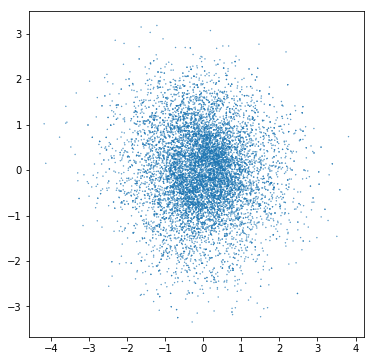

In [90]:
encoder = Model(x, z_mean)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(batch_1, batch_size=batch_size)
plt.figure(figsize=(6, 6))
s = [0.5 for n in range(len(x_test_encoded[:, 1]))]
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], marker='.',s=s)
#plt.colorbar()
plt.show()

In [126]:
encoder = Model(x, z_mean)
decoder_half_input = Input(shape=(latent_dim,))

decoder_input = Input(shape=(latent_dim*2,))

test_1, test_2, test_3 = mnist.test.next_batch(batch_size)#4000)
#whl = Model(inputs=[x,x2,x_sum],outputs=[x_decoded_mean, x_decoded_mean2, decoded_mean_sum])
print(test_1.shape)
zz = encoder.predict(test_1, batch_size=batch_size)
zz1 = encoder.predict(test_2, batch_size=batch_size)

ste1 = decoder_h_ly(decoder_half_input)
agen1 = decoder_mean_ly(ste1)
autodec = Model(decoder_half_input,agen1)

image1 = autodec.predict(zz, batch_size=batch_size)
image2 = autodec.predict(zz1, batch_size=batch_size)


print(zz.shape)
print(zz1.shape)
#decoder_input = concatenate([z, z1])
zzm = np.hstack([zz,zz1])
print(zzm.shape)

summ = decoder_h_sum_ly(decoder_input)
sum_img = decoder_mean_sum_ly(summ)
sum_gen = Model(decoder_input,sum_img)
out_sum_img = sum_gen.predict(zzm, batch_size=batch_size)
print(out_sum_img.shape)
#rint(sum_img.shape)

(100, 784)
(100, 32)
(100, 32)
(100, 64)
(100, 784)


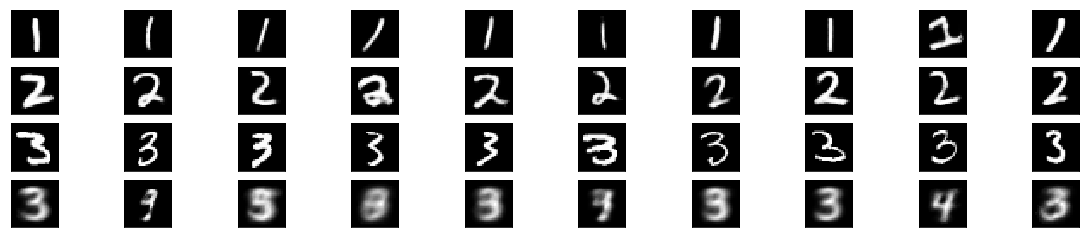

In [127]:
n = 10  # how many digits we will display
sam =40
plt.figure(figsize=(20, 4))
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(4, n, i + 1)
    im1 = image1[i+sam].reshape(28,28)
    plt.imshow(im1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, i + 1 + n)
    im2 = image2[i+sam].reshape(28,28)
    plt.imshow(im2)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n*2)
#    plt.imshow(decoded_imgs[i+sam].reshape(28, 28))
    plt.imshow(test_3[i+sam].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i + 1 + n*3)
    plt.imshow(out_sum_img[i+sam].reshape(28, 28))
#    plt.imshow(test_sum[i+sam].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [128]:
vae.save('model.h5')

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.